# Programmatic Access of Spectroscopic Data

You will learn

SSHADE
TAP Queries
Write a class to make programming more comfortable

## TAP Queries

The [Table Access Protocol](https://www.ivoa.net/documents/TAP/) (TAP) is a Virtual-Observatory service for accessing tables
via, among other languages, an SQL-like query language called ADQL (Astronomical Data Query Language). Many astronomical dataservices are 
accessible via TAP, such as Gaia, ...

TAP queries can be executed with standard graphical user interfaces such as TOPCAT and Aladin.

## Access of SSHADE database via TAP

The SSHADE database does not have an API to access spectra directly. However, the metadata of the SSHADE is accessible via TAP.
We start by querying the service connecting to the service using the [pyvo](https://pyvo.readthedocs.io/en/latest/) package.

In [12]:
import pyvo as vo

service = vo.dal.TAPService("http://osug-vo.osug.fr:8080/tap")

The URL of the service you want to connect to is typically given on their website. In SSHADE's case, neither the URL nor
the server response are documented on the webpage. To prepare this tutorial, we instead got the information by looking at how TOPCAT
connects to SSHADE. Besides the URL, this also tells us which table we have to query, which we do below

In [13]:
sshade = service.search("SELECT * FROM sshade_spectra.epn_core")  # get all entries of SSHADE metadata
sshade = sshade.to_table().to_pandas()  # convert the resulting object to a pandas DataFrame
print(f"Retrieved metadata of {len(sshade)} spectra from SSHADE")

Retrieved metadata of 6324 spectra from SSHADE


What did we just query? Let's inspect.

In [14]:
print(sshade.columns)

Index(['granule_uid', 'granule_gid', 'obs_id', 'dataproduct_type',
       'target_name', 'target_class', 'time_min', 'time_max',
       'time_sampling_step_min', 'time_sampling_step_max', 'time_exp_min',
       'time_exp_max', 'spectral_range_min', 'spectral_range_max',
       'spectral_sampling_step_min', 'spectral_sampling_step_max',
       'spectral_resolution_min', 'spectral_resolution_max', 'c1min', 'c1max',
       'c2min', 'c2max', 'c3min', 'c3max', 's_region', 'c1_resol_min',
       'c1_resol_max', 'c2_resol_min', 'c2_resol_max', 'c3_resol_min',
       'c3_resol_max', 'spatial_frame_type', 'incidence_min', 'incidence_max',
       'emergence_min', 'emergence_max', 'phase_min', 'phase_max',
       'instrument_host_name', 'instrument_name', 'measurement_type',
       'processing_level', 'creation_date', 'modification_date',
       'release_date', 'service_title', 'access_url', 'access_format',
       'access_estsize', 'access_md5', 'time_scale', 'thumbnail_url',
       'publisher',

Typical metadata columns and more cryptic ones.


In [15]:
print(sshade['granule_uid'])
print(sshade['granule_gid'])
print(sshade['obs_id'])
print(sshade['target_name'])
print(sshade['target_class'])
print(sshade['sample_classification'])

0          SPECTRUM_DT_20170706_006
1          SPECTRUM_GS_20161207_001
2        SPECTRUM_DT_20161207_003_3
3        SPECTRUM_DT_20161207_005_3
4        SPECTRUM_DT_20161207_005_6
                   ...             
6319    SPECTRUM_CF_20200813_08_000
6320    SPECTRUM_CF_20200813_02_000
6321    SPECTRUM_CF_20200813_00_000
6322    SPECTRUM_CF_20200813_09_000
6323    SPECTRUM_CF_20200813_10_000
Name: granule_uid, Length: 6324, dtype: object
0         EXPERIMENT_DT_20170706_006
1         EXPERIMENT_GS_20161207_001
2       EXPERIMENT_DT_20161207_001.2
3       EXPERIMENT_DT_20161207_001.2
4       EXPERIMENT_DT_20161207_001.2
                    ...             
6319      EXPERIMENT_CF_20200813_000
6320      EXPERIMENT_CF_20200813_000
6321      EXPERIMENT_CF_20200813_000
6322      EXPERIMENT_CF_20200813_000
6323      EXPERIMENT_CF_20200813_000
Name: granule_gid, Length: 6324, dtype: object
0          SPECTRUM_DT_20170706_006
1          SPECTRUM_GS_20161207_001
2        SPECTRUM_DT_20161207_0

<!-- Next, we encounter a weakness of TAP. Since it is a protocol, the tables it connects to need to follow a certain format, in particular concerning -->
<!-- their column names. Since there are tables covering many different astronomical topics, making them all fit into one uniform schema necessarily leads -->
<!-- to some concessions. In this case, the column names are not necessarily the best descriptors of the cell content, and we miss a column containing a clear yet -->
<!-- concise description of the sample. -->

 <!-- the metadata is difficult to search for as important keys like target class are missing (concatenated in sample_classification) -->

We select the spectra of different carbonaceous chondrites  published in Beck+ 2021. We get the required `granule_gid` from the
[SSHADE website of the experiment](https://www.sshade.eu/data/EXPERIMENT_LB_20200902_001).


In [22]:
beck21 = sshade[sshade['granule_gid'] == "EXPERIMENT_LB_20200902_001"]

We download the spectra using the `requests` library. The format is `VOTable`, which we can open with the `astropy` package.
Once again, we use the `io.BytesIO` function as neat trick to not store the spectra on file but to open them directly.
In general, it makes sense to store them, to avoid repeated queries to the server.

We download the spectra by iterating over the `beck21` dataframe and using the `access_url` in each row.

In [33]:
import io

import astropy
import requests

# Download spectra to local machine
for _, spec in beck21[:1].iterrows():
    r = requests.get(spec.access_url)
    # TODO: add line that stores the spectra
    s = astropy.io.votable.parse(io.BytesIO(r.content))
    print(s)
s.get_first_table().to_table()

<VOTABLE>... 1 tables ...</VOTABLE>


wavelength,intensity_i0e10a0,error_i0e10a0,intensity_i0e20a0,error_i0e20a0,intensity_i0e30a0,error_i0e30a0
nm,,,,,,
float32,float32,float32,float32,float32,float32,float32
400.0,0.062727,0.000653,0.052139,0.001002,0.048785,0.000647
500.0,0.088927,0.000129,0.077723,0.000182,0.072136,0.000123
600.0,0.108349,4.8e-05,0.096115,3.6e-05,0.090192,8.8e-05
700.0,0.109839,2.7e-05,0.097519,2.8e-05,0.091595,2.5e-05
800.0,0.109781,1e-05,0.097808,2.3e-05,0.092532,1.2e-05
900.0,0.108915,0.000201,0.097556,0.000208,0.092087,0.00021
1000.0,0.105504,0.002255,0.099331,0.001792,0.09124,0.001857
1100.0,0.109417,0.00179,0.097806,0.002322,0.093345,0.000889


And plot


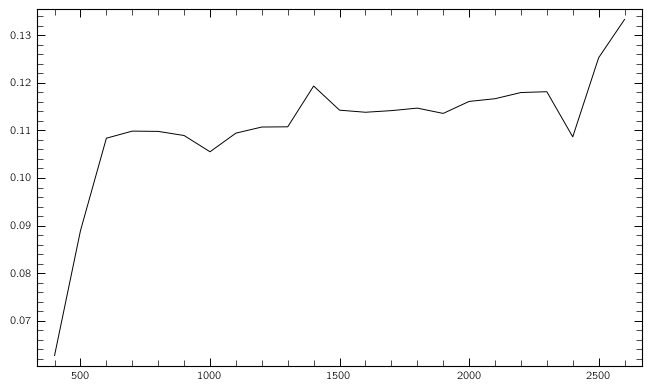

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(s.get_first_table().array['wavelength'], s.get_first_table().array['intensity_i0e10a0'])

Again, we see that we can access, but the coding afterwards remains uncomfortable.

<!-- ## Asteroids -->
<!---->
<!-- classy -->

<!-- ## A Linkage Application -->

## Making it more comfortable with OOP

In [ ]:

class Spectrum:

  def __init__(self, data, i=0, e=10, a=0):


    self.i = i
    self.e = e 
    self.a = a

    self.wave = data["wavelength"]
    self.refl = data[f"intensity_i{i}e{e}a{a}"]

  # def plot(self):

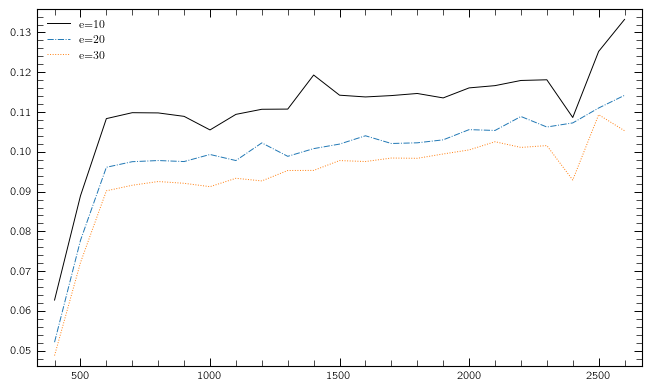

In [44]:
spec_e10 = Spectrum(s.get_first_table().array, e=10)
spec_e20 = Spectrum(s.get_first_table().array, e=20)
spec_e30 = Spectrum(s.get_first_table().array, e=30)

spectra = [spec_e10, spec_e20, spec_e30]


fig, ax = plt.subplots()

for spec in spectra:
  ax.plot(spec.wave, spec.refl, label=f"e={spec.e}")

ax.legend()
plt.show()

